- Adam Napora
- 18197892

### Etivity 2: Task 1 and 2, SARSA

#### Task 1:
Implement tabular Sarsa (**this Notebook**) AND Q-Learning for the problem outlined in Exercise 6.5 (Windy Grid World)

#### Task 2:
Analyse the impact of varying parameters such as reward and action selection

In [13]:
#%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [82]:
# Import necessary libraries
import numpy as np
import random
from IPython.display import clear_output
from matplotlib import pyplot as plt
import seaborn as sns
import time
from tqdm.notebook import tqdm_notebook
import itertools
sns.set_style('whitegrid')
import gym
import gym_windy_gridworlds

#### Windy Grid Worlds OpenAI Gym env. installation:

This gym environment can be installed using a 3rd party package: https://github.com/ibrahim-elshar/gym-windy-gridworlds. Requires to clone the repo and install using **pip**

### Task 1

Theory from https://www.geeksforgeeks.org/sarsa-reinforcement-learning/

**Q-Learning** technique is an Off Policy technique and uses the greedy approach to learn the Q-value.

**SARSA** technique, on the other hand, is an On Policy and uses the action performed by the current policy to learn the Q-value.

- **On Policy:** In this, the learning agent learns the value function according to the current action derived from the policy currently being used
- **Off Policy:** In this, the learning agent learns the value function according to the action derived from another policy

In [71]:
# create Gym environment
env = gym.make('WindyGridWorld-v0')

In [72]:
# number of possible states
state_space_size = env.observation_space
print('rows:', state_space_size[0].n, 'cols:', state_space_size[1].n)

rows: 7 cols: 10


In [73]:
# number of possible actions
action_space_size = env.action_space.n
print('actions:', action_space_size)

actions: 4


In [75]:
def run(num_episodes=1000, max_steps_per_episode=500, learning_rate=0.1,
        discount_rate=0.99, exploration_rate=0.1):
    """
    Run experiment for num_episodes/max_steps_per_episode
    :param num_episodes int - how many total episodes
    :param max_steps_per_episode int - how many steps inside each episode
    :param learning_rate float - alpha
    :param discount_rate float - gamma
    :param exploration_rate float - epsilon ϵ, probability that agent will choose to explore
    :return rewards_all_episodes dict - rewards for each episode and steps required to reach the Goal
    """
    
    # define handy function, which will perform the SARSA Q-Table update
    def calc_q_update(state, new_state, reward, action, new_action):
        target = reward + discount_rate * q_table[new_state][new_action]
        pred = q_table[state][action]
        return pred + learning_rate * (target - pred)
        
    # define handy function to choose to either exploit or explore
    def choose_action(state):
        # draw a random number between 0 and 1
        exploration_rate_threshold = random.uniform(0, 1)
        # based on random number, check if we are exploring or exploiting
        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[state])  # we are exploting, use a number from q-table
        else:
            action = env.action_space.sample()  # we are exploring & taking a random action
        return action
    
    # initialise q table, which we will update on each step inside each eposide
    q_table = np.zeros((state_space_size[0].n, state_space_size[1].n, action_space_size))
    
    # keep track of all rewards
    rewards_all_episodes = []
    
    # monitor how many steps it took in each episode for success
    steps_to_complete = []

    # Sarsa algo
    for episode in range(num_episodes):
        # reset variables for each episode
        state = env.reset()
        action = choose_action(state)
        done = False
        rewards_current_episode = 0
        
        for step in range(max_steps_per_episode):

            # take next step and calculate future state and reward
            new_state, reward, done, info = env.step(action)
            
            # choose action, exploit (use Q-Table) or explore (random)
            new_action = choose_action(new_state)

            # Use formula from BartoSutton RL book, 6.4, page 130:
            # Q(S,A) <- Q(S,A) + α[R + γ*Q(S',A') - Q(S,A)]
            q_table[state][action] = calc_q_update(state, new_state, reward, action, new_action)

            state = new_state  # set the current state to new state
            action = new_action  # set current action to new action
            rewards_current_episode += reward  # add to rewards in current episode

            # stop if done
            if done == True:
                # print(f'Done. Episode {episode}, step {step}')
                steps_to_complete.append(step)
                break

        rewards_all_episodes.append(rewards_current_episode)
    return {
        'rewards': rewards_all_episodes,
        'goal_steps': steps_to_complete,
        'q_table': q_table
    }

In [76]:
results = run()
q_table = results['q_table']

In [100]:
# visualise how the Agent behaves in the Gym environment,
# thanks to deeplizard.com Blog (https://deeplizard.com/learn/video/ZaILVnqZFCg)
max_steps_per_episode = 100
for episode in range(3):
    print(f'Episode: {episode+1}')
    state = env.reset()
    print(state)
    done = False
    time.sleep(0.5)
    for step in range(max_steps_per_episode):
        clear_output(wait=True); env.render(); time.sleep(0.1)
        action = np.argmax(q_table[state])
        new_state, reward, done, info = env.step(action)
        if done:
            clear_output(wait=True); env.render(); time.sleep(1); clear_output(wait=True)
            break
        state = new_state

############
#          #
#          #
#          #
#S      X  #
#          #
#          #
#          #
############



#### Note:
Agent was able to reach the goal in all 3 episodes

#### Explore parameter space using SARSA algorithm

In [83]:
learning_rates = [0.1, 0.01]  # α - how quickly we want to learn
discount_rates = [0.99, 0.98]  # γ - how much importance we assign to future states
exploration_rates = [0.1, 0.5, 0.9]  # ϵ - how much we want to rely on exploration (high value) and exploitation

# create each possible combination of the parameters and run the algorithm for each
lists = [learning_rates, discount_rates, exploration_rates]
results = []
combinations = [el for el in itertools.product(*lists)]
for i in tqdm_notebook(range(len(combinations))):
    learning_rate, discount_rate, exploration_rate = combinations[i]
    results.append({
        'params': (learning_rate, discount_rate, exploration_rate),
        'results': run(learning_rate=learning_rate, discount_rate=discount_rate, 
            exploration_rate=exploration_rate)
        })

#### Plot Reward quantity by episode

>> Rewards by episode:


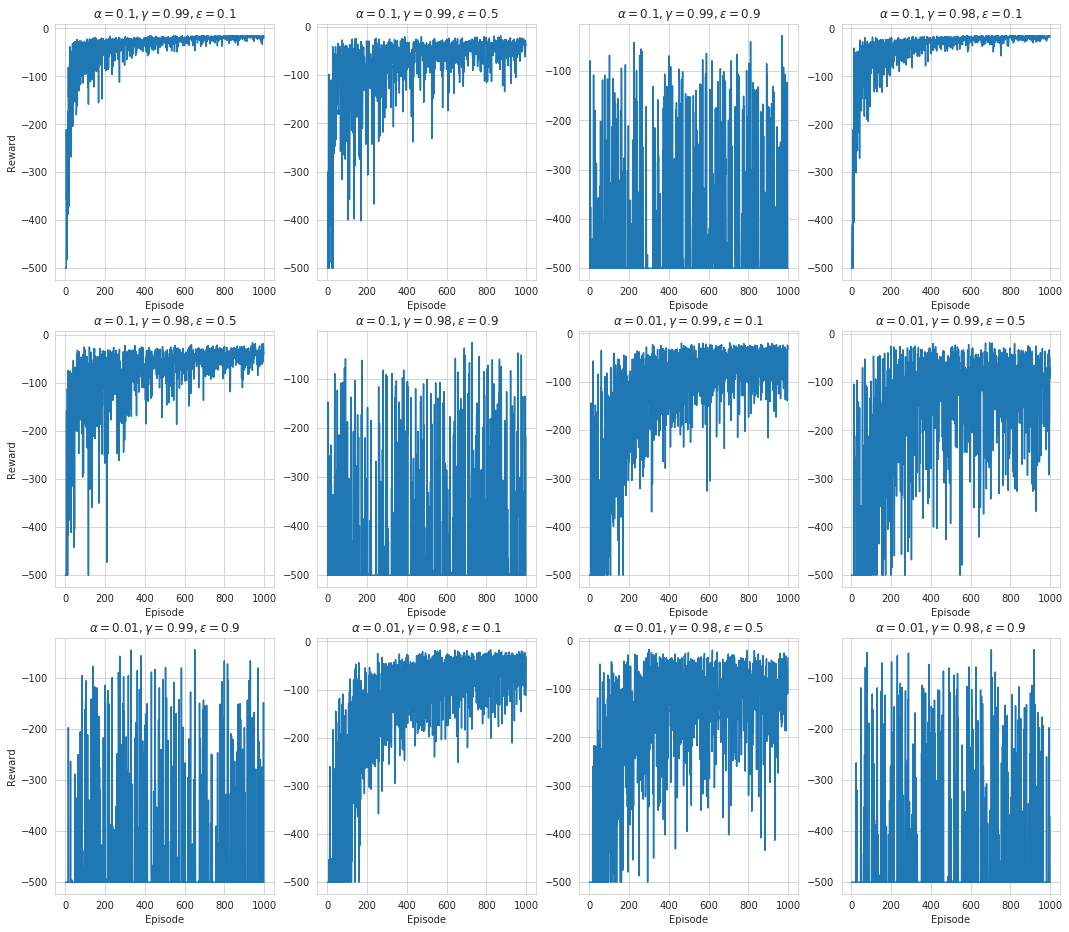

In [84]:
# create plots for rewards across episodes for all parameter combinations
f, axis = plt.subplots(3, 4)
f.set_figheight(16); f.set_figwidth(18)
plot_count = 0
print('>> Rewards by episode:')
for ax in axis:
    for a in ax:
        a.plot(results[plot_count]['results']['rewards'])
        params = results[plot_count]["params"]
        a.set_title(f'$\\alpha={params[0]},\gamma={params[1]},\epsilon={params[2]}$')
        a.set_xlabel('Episode')
        if plot_count % 4 == 0: a.set_ylabel('Reward')
        plot_count += 1

#### Plot Number of steps to achieve Goal by episode

>> Steps to Goal by episode:


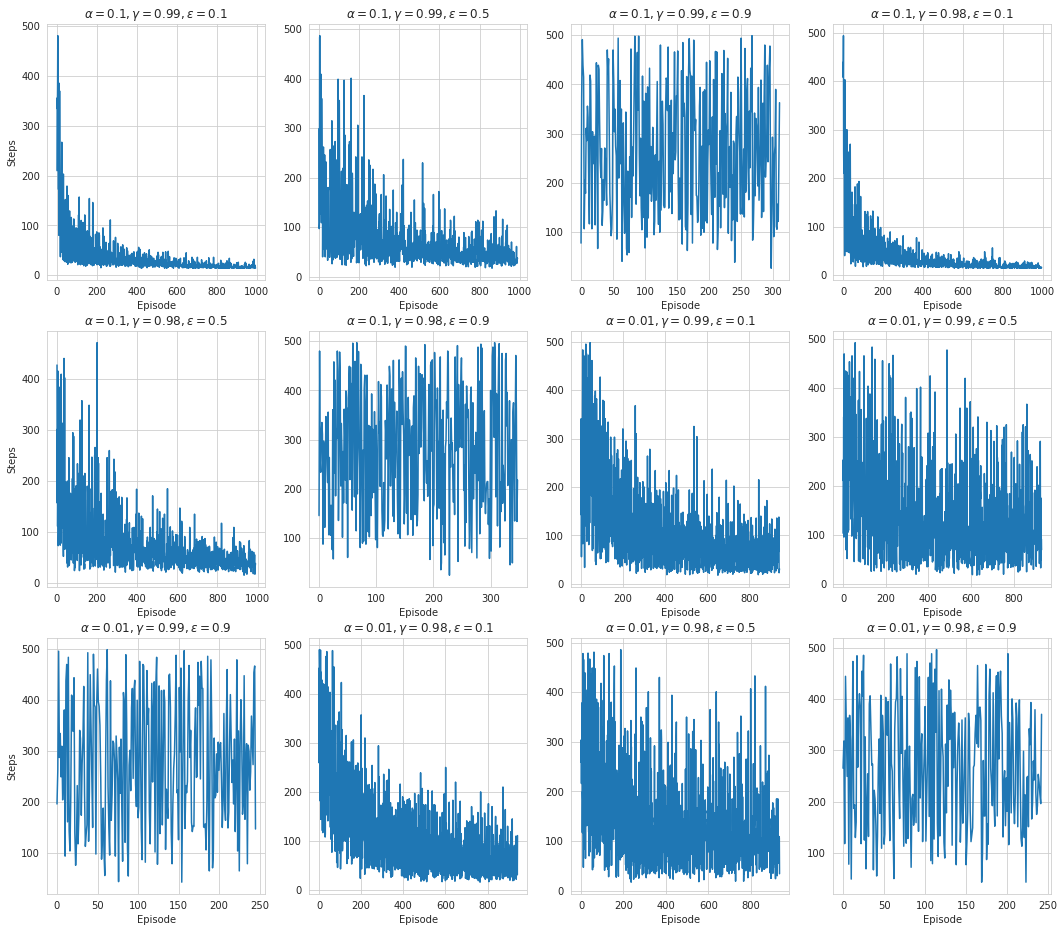

In [85]:
# create plots for number of steps to reach the goal across episodes for all parameter combinations
f, axis = plt.subplots(3, 4)
f.set_figheight(16); f.set_figwidth(18)
plot_count = 0
print('>> Steps to Goal by episode:')
for ax in axis:
    for a in ax:
        a.plot(results[plot_count]['results']['goal_steps'])
        params = results[plot_count]["params"]
        a.set_title(f'$\\alpha={params[0]},\gamma={params[1]},\epsilon={params[2]}$')
        a.set_xlabel('Episode')
        if plot_count % 4 == 0: a.set_ylabel('Steps')
        plot_count += 1

### Note:

I have observed the best Reward increase for parameters: $\alpha=0.1,\gamma=0.99,\epsilon=0.1$

If the learning rate is too low, Agent is not learning fast enough and if the exploration rate is too high, Agent takes too many random choices. Seems like the discount rate does not play as cruitial role as other parameters.

#### Experiment with dynamic $\epsilon$:

Implement a version of Q-Learning with dynamic Exploration Rate and see how it affects the performance. Algorithm will update exploration rate after each episode according to the formula:

$\epsilon=\epsilon_{min}+(\epsilon_{max}-\epsilon_{min})*\exp^{-\epsilon_{decay}*N}$

In [88]:
def run_eps_decay(num_episodes=1000, max_steps_per_episode=500, learning_rate=0.1,
        discount_rate=0.99, exploration_rate=0.1, eps_decay=False):
    """
    Run experiment for num_episodes/max_steps_per_episode
    :param num_episodes int - how many total episodes
    :param max_steps_per_episode int - how many steps inside each episode
    :param learning_rate float - alpha
    :param discount_rate float - gamma
    :param exploration_rate float - epsilon ϵ, probability that agent will choose to explore
    :return rewards_all_episodes dict - rewards for each episode and steps required to reach the Goal
    """
    
    # define handy function, which will perform the SARSA Q-Table update
    def calc_q_update(state, new_state, reward, action, new_action):
        target = reward + discount_rate * q_table[new_state][new_action]
        pred = q_table[state][action]
        return pred + learning_rate * (target - pred)
        
    # define handy function to choose to either exploit or explore
    def choose_action(state):
        # draw a random number between 0 and 1
        exploration_rate_threshold = random.uniform(0, 1)
        # based on random number, check if we are exploring or exploiting
        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[state])  # we are exploting, use a number from q-table
        else:
            action = env.action_space.sample()  # we are exploring & taking a random action
        return action
    
    # initialise q table, which we will update on each step inside each eposide
    q_table = np.zeros((state_space_size[0].n, state_space_size[1].n, action_space_size))
    
    # keep track of all rewards
    rewards_all_episodes = []
    
    # monitor how many steps it took in each episode for success
    steps_to_complete = []

    # Sarsa algo
    for episode in range(num_episodes):
        # reset variables for each episode
        state = env.reset()
        action = choose_action(state)
        done = False
        rewards_current_episode = 0
        
        for step in range(max_steps_per_episode):

            # take next step and calculate future state and reward
            new_state, reward, done, info = env.step(action)
            
            # choose action, exploit (use Q-Table) or explore (random)
            new_action = choose_action(new_state)

            # Use formula from BartoSutton RL book, 6.4, page 130:
            # Q(S,A) <- Q(S,A) + α[R + γ*Q(S',A') - Q(S,A)]
            q_table[state][action] = calc_q_update(state, new_state, reward, action, new_action)

            state = new_state  # set the current state to new state
            action = new_action  # set current action to new action
            rewards_current_episode += reward  # add to rewards in current episode

            # stop if done
            if done == True:
                # print(f'Done. Episode {episode}, step {step}')
                steps_to_complete.append(step)
                break
        
        if eps_decay == True:
            exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * \
                np.exp(-exploration_decay_rate*episode)
        
        rewards_all_episodes.append(rewards_current_episode)
    return {
        'rewards': rewards_all_episodes,
        'goal_steps': steps_to_complete,
        'q_table': q_table
    }

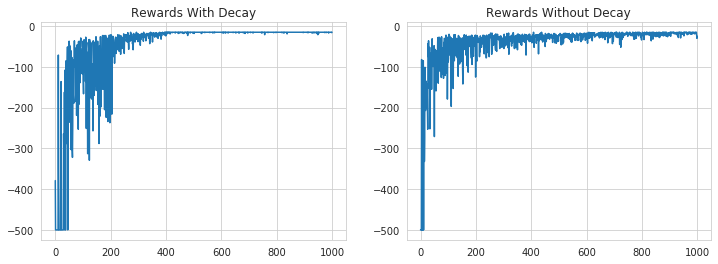

In [92]:
# set up parameters for exponential decay
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.01
start_exploration_rate = 1

decay_results = run_eps_decay(exploration_rate=start_exploration_rate, eps_decay=True)
no_decay_results = run_eps_decay(exploration_rate=0.1, eps_decay=False)
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_figheight(4); f.set_figwidth(12)
ax1.plot(decay_results['rewards'])
ax1.set_title('Rewards With Decay')
ax2.plot(no_decay_results['rewards'])
ax2.set_title('Rewards Without Decay');

In [93]:
# print mean reward for a batch of episodes (with decay)
print('WITH DECAY:')
print(np.mean(decay_results['rewards'][600:700]))
print(np.mean(decay_results['rewards'][700:800]))
print(np.mean(decay_results['rewards'][800:900]))
print(np.mean(decay_results['rewards'][900:1000]))

WITH DECAY:
-15.26
-15.16
-15.12
-15.25


In [94]:
# print mean reward for a batch of episodes (without decay)
print('WITHOUT DECAY:')
print(np.mean(no_decay_results['rewards'][600:700]))
print(np.mean(no_decay_results['rewards'][700:800]))
print(np.mean(no_decay_results['rewards'][800:900]))
print(np.mean(no_decay_results['rewards'][900:1000]))

WITHOUT DECAY:
-21.93
-20.61
-19.06
-17.23


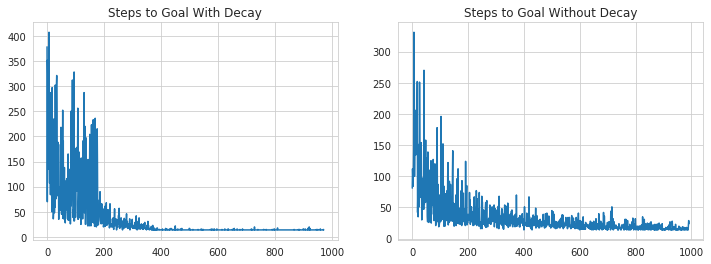

In [95]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_figheight(4); f.set_figwidth(12)
ax1.plot(decay_results['goal_steps']);
ax1.set_title('Steps to Goal With Decay')
ax2.plot(no_decay_results['goal_steps'])
ax2.set_title('Steps to Goal Without Decay');

In [96]:
# print mean reward for a batch of episodes (with decay)
print('WITH DECAY:')
print(np.mean(decay_results['goal_steps'][600:700]))
print(np.mean(decay_results['goal_steps'][700:800]))
print(np.mean(decay_results['goal_steps'][800:900]))
print(np.mean(decay_results['goal_steps'][900:1000]))

WITH DECAY:
14.19
14.18
14.11
14.291666666666666


In [97]:
# print mean reward for a batch of episodes (without decay)
print('WITHOUT DECAY:')
print(np.mean(no_decay_results['goal_steps'][600:700]))
print(np.mean(no_decay_results['goal_steps'][700:800]))
print(np.mean(no_decay_results['goal_steps'][800:900]))
print(np.mean(no_decay_results['goal_steps'][900:1000]))

WITHOUT DECAY:
20.46
19.71
17.76
16.26086956521739


In [99]:
# pickle results so we can load them for final analysis
import pickle
pickle.dump(decay_results, open("sarsa_with_decay_results.pickle", "wb"))
pickle.dump(no_decay_results, open("sarsa_no_decay_results.pickle", "wb"))

#### Note:

As we can see above, we can improve the Reward by using exploration rate decay technique. The average reward between batches 700 and 800 are:
- -15.2 for algorithm **with** exponential decay
- -20.6 for algorithm **without** exponential decay

Exponential rate decay also influences the mean number of steps needed to reach the goal. Here are the statistics between episodes 700 and 800:

- 14.2 for algorithm with exponential decay
- 19.7 for algorithm without exponential decay

### References:
- BartoSutton RL Book - 2018
- https://www.geeksforgeeks.org/sarsa-reinforcement-learning/
- https://github.com/ibrahim-elshar/gym-windy-gridworlds
- https://deeplizard.com/learn/video/ZaILVnqZFCg